# Chicago 311 Service Abandoned vehicle  - historical request data.   

### MACS Machine Learning final project  





Abandoned cars are a continuous issues in urban areas across the nation, especially in Chicago due to extreme population density.Having abandoned cars lead to social issues which costs the city and taxpayers money due to increase in hazardous waste, littering, general blight, etc. So the objective is to provided a new feature as 'Estimated time to Complete Service' to allow the Citizen of Chicago to better improve their calling experience.

All open abandoned vehicle complaints made to 311 and all requests completed since 1/1/11. This data is collated from public requests on the 311 app. This data set has data through 7/23/20 and can be publicly accessed here: 311 Service Requests - Abandoned Vehicles – Historical：https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Abandoned-Vehicles-Historical/3c9v-pnva.

So I'm utilizing Regression, Polynominial Regression and Regularized Linear Model to predict the expected processing time for the vehicle to be towed to provide towards the citizens when report the abandoned vehicle.

In [1]:
#lets setup our import statements
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import recordlinkage as rl
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time, timezone
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

#311_Service_Requests_-_Abandoned_Vehicles_-_Historical.csv

In [2]:
#read in dataset.  Assumes file is in the same directory as the notebook. 
df = pd.read_csv('./311_Service_Requests_-_Abandoned_Vehicles_-_Historical.csv')
print (df.shape)

(261486, 22)


In [3]:
#here we're checking what we imported to see how it looks.  
df.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261486 entries, 0 to 261485
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   Creation Date                                           261486 non-null  object 
 1   Status                                                  261486 non-null  object 
 2   Completion Date                                         257501 non-null  object 
 3   Service Request Number                                  261486 non-null  object 
 4   Type of Service Request                                 261486 non-null  object 
 5   License Plate                                           240743 non-null  object 
 6   Vehicle Make/Model                                      240115 non-null  object 
 7   Vehicle Color                                           245886 non-null  object 
 8   Current Activity        

In [4]:
#we can describe numeric fields to see what values look like.   definitely some cases of missing ward values
#we'll need to look out for those. 
df.describe()

,How Many Days Has the Vehicle Been Reported as Parked?,ZIP Code,X Coordinate,Y Coordinate,Ward,Police District,Community Area,SSA,Latitude,Longitude
count,2.174950e+05,261020.000000,1.768160e+05,1.768160e+05,261079.000000,261079.000000,261079.000000,33998.000000,260557.000000,260557.000000
mean,4.602407e+11,60601.537852,1.157781e+06,1.894504e+06,25.757472,13.229007,35.133642,32.863698,41.865719,-87.695342
std,2.144251e+14,1358.079473,1.675354e+04,3.321456e+04,13.734464,6.853680,22.777940,17.509855,0.091636,0.060607
min,-5.234545e+08,0.000000,6.923780e+05,1.813943e+06,0.000000,0.000000,0.000000,1.000000,41.644497,-87.913726
25%,1.200000e+01,60620.000000,1.146896e+06,1.864966e+06,14.000000,8.000000,16.000000,21.000000,41.784567,-87.734709
50%,2.100000e+01,60630.000000,1.156857e+06,1.901479e+06,26.000000,12.000000,28.000000,33.000000,41.883272,-87.698036
75%,3.000000e+01,60641.000000,1.168122e+06,1.922894e+06,37.000000,18.000000,58.000000,48.000000,41.944648,-87.657847
max,1.000000e+17,60827.000000,1.205117e+06,1.951493e+06,50.000000,31.000000,77.000000,69.000000,42.022660,-87.524478


In [5]:
#lets get a view of our missing fields
df.isnull().sum(axis = 0)

Creation Date                                                  0
Status                                                         0
Completion Date                                             3985
Service Request Number                                         0
Type of Service Request                                        0
License Plate                                              20743
Vehicle Make/Model                                         21371
Vehicle Color                                              15600
Current Activity                                           32074
Most Recent Action                                         33098
How Many Days Has the Vehicle Been Reported as Parked?     43991
Street Address                                               111
ZIP Code                                                     466
X Coordinate                                               84670
Y Coordinate                                               84670
Ward                     

## 1.Data Cleaning

In [6]:
#drop NA records where ward, police district, community area are missing.  
df_clean = df.dropna(subset=['Ward','Police District','Community Area'])

In [7]:
#run a new set of counts. 
df_clean.isnull().sum(axis = 0)

Creation Date                                                  0
Status                                                         0
Completion Date                                             3969
Service Request Number                                         0
Type of Service Request                                        0
License Plate                                              20696
Vehicle Make/Model                                         21305
Vehicle Color                                              15561
Current Activity                                           31805
Most Recent Action                                         32829
How Many Days Has the Vehicle Been Reported as Parked?     43739
Street Address                                                 0
ZIP Code                                                     297
X Coordinate                                               84469
Y Coordinate                                               84469
Ward                     

In [8]:
#set text fields to uppercase to prevent duplication in different case
text_features = ['Status','Type of Service Request','License Plate','Vehicle Make/Model','Vehicle Color','Current Activity','Most Recent Action','Street Address']
for text_feature in text_features:
    df_clean[text_feature] = df_clean[text_feature].str.upper()

/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/1965463514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[text_feature] = df_clean[text_feature].str.upper()


In [9]:
#now lets check our creation date fields.f
print(pd.DatetimeIndex(df_clean['Creation Date']).min())
print(pd.DatetimeIndex(df_clean['Creation Date']).max())

1999-12-28 00:00:00
2020-07-23 00:00:00


In [10]:
#break off the creation datetime part so we can review counts by year,month and day
df_clean["creation_year"] = pd.DatetimeIndex(df_clean['Creation Date']).year
df_clean["creation_month"] = pd.DatetimeIndex(df_clean['Creation Date']).month
df_clean["creation_day"] = pd.DatetimeIndex(df_clean['Creation Date']).day

/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/188121213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["creation_year"] = pd.DatetimeIndex(df_clean['Creation Date']).year
/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/188121213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["creation_month"] = pd.DatetimeIndex(df_clean['Creation Date']).month
/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/188121213.py:4: SettingWithCopyWarnin

In [11]:
df_gb = df_clean.groupby(['creation_year']).count()

<AxesSubplot:xlabel='creation_year'>

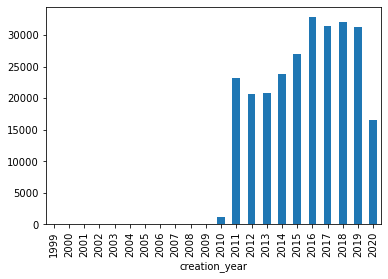

In [12]:
#plot creation date counts by year. 
df_gb['Creation Date'].plot(kind = 'bar')

In [13]:
#lets limit our records to just 2010 or later
df_clean = df_clean[df_clean['creation_year']>=2010]
print(pd.DatetimeIndex(df_clean['Creation Date']).min())
print(pd.DatetimeIndex(df_clean['Creation Date']).max())

2010-01-13 00:00:00
2020-07-23 00:00:00


In [14]:
#since there's inconsistent data from 2010, we'll limit to 2011.  
df_clean = df_clean[df_clean['creation_year']>=2011]
print(pd.DatetimeIndex(df_clean['Creation Date']).min())
print(pd.DatetimeIndex(df_clean['Creation Date']).max())

2011-01-01 00:00:00
2020-07-23 00:00:00


In [15]:
#lets look at days reported as parked.  
print(df_clean['How Many Days Has the Vehicle Been Reported as Parked?'].min())
print(df_clean['How Many Days Has the Vehicle Been Reported as Parked?'].max())

-523454546.0
1e+17


In [16]:
#looks like most values only have a single entry. 
df_clean.groupby(['How Many Days Has the Vehicle Been Reported as Parked?']).size()

How Many Days Has the Vehicle Been Reported as Parked?
-5.234545e+08    1
-7.620000e+02    1
-7.200000e+02    1
-6.900000e+02    3
-6.000000e+02    1
                ..
 7.738516e+09    1
 7.738669e+09    1
 1.000000e+10    1
 1.000000e+14    1
 1.000000e+17    1
Length: 575, dtype: int64

In [17]:
#since our range is only 10 years of data we'll cap days as 4000 (around 11 years)
#and we'll set anything less than 0 to be equal to 0. Since we can't have a negative number
df_clean['days_reported_clean'] = df_clean['How Many Days Has the Vehicle Been Reported as Parked?']
df_clean.loc[df_clean['days_reported_clean'] >= 4000,'days_reported_clean'] = 4000
df_clean.loc[df_clean['days_reported_clean'] < 0,'days_reported_clean'] = 0

<AxesSubplot:xlabel='days_reported_clean'>

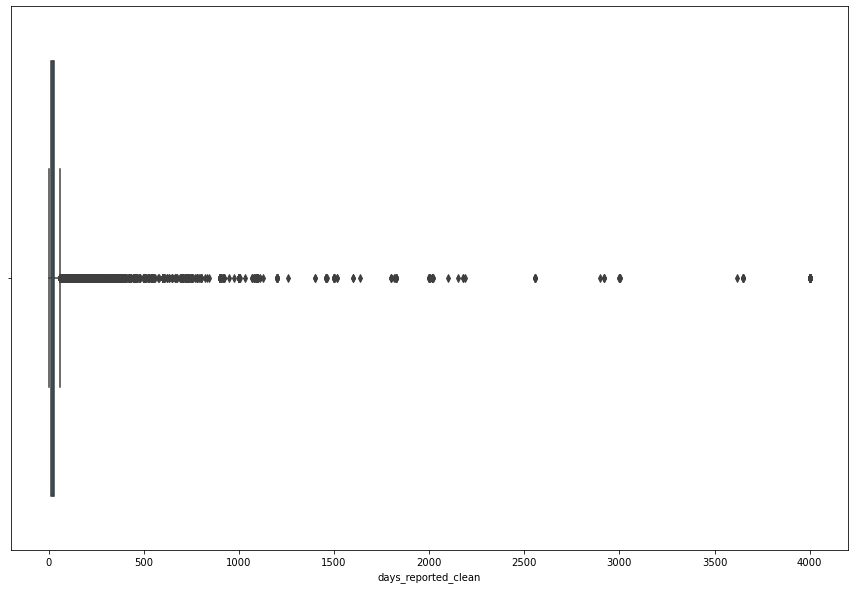

In [18]:
#looks like we have a lot of outliers for this particular field, but at least none of the entries are nonsensical anymore.  
plt.figure(figsize=(15,10))
sns.boxplot(x=df_clean['days_reported_clean'])

In [19]:
#Looking at license plate values we have a lot of mess there. 
#We'll need to be extra careful working with fields like "none", 
#"unknown" and "no plates" when we're trying to de-dup records. 
missing_value_names = df_clean['License Plate'].value_counts()[:50]
missing_value_list = missing_value_names.index.tolist()

In [20]:
#lets clean up some of the top offenders.  we'll brute force this untill we don't have any weird values (beyond missing) in 
#the top 50 values. 
for missing_value in missing_value_list:
    df_clean.loc[df_clean["License Plate"] == missing_value, "License Plate"] = 'MISSING'

In [21]:
df_clean['License Plate'].value_counts()[:50]

MISSING                  33538
NO INFO.                    40
NO INFO                     39
??????????                  39
7087833                     38
DON'T KNOW                  37
14520                       37
NON                         37
NO FRONT PLATE              36
CEJAS                       35
C869351                     35
E650226                     34
????????                    34
NONE PROVIDED               33
1773233                     33
XXXXXXX                     32
NO PLATES OR STICKER        32
V75 8957                    32
99999                       31
N/P                         31
NO PLATES OR STICKERS       30
123456                      30
TEMPORARY PLATE             30
DOESNT KNOW PLATE           29
NO PLATES ON VEHICLE        29
CAN'T SEE                   29
UNKN                        28
-                           28
P118563                     28
BM25626                     28
A895425                     28
BR 78641                    27
528 5859

In [22]:
missing_value_list1 = ["TEMPORARY PLATES","NO INFO.","??????????","NO INFO","NON","DON'T KNOW","NO FRONT PLATE",
                      "????????","NONE PROVIDED","NO PLATES OR STICKER","XXXXXXX","N/P","TEMPORARY PLATE","123456",
                       "NO PLATES OR STICKERS","NO PLATES ON VEHICLE","CAN'T SEE","DOESNT KNOW PLATE","-","UNKN",
                       "MISSING PLATES..","??????","LP","NOPLATE","INDIANA"]
for missing_value in missing_value_list1:
    df_clean.loc[df_clean["License Plate"] == missing_value, "License Plate"] = 'MISSING'

In [23]:
df_clean['License Plate'].value_counts()[:50]

MISSING                      34287
7087833                         38
14520                           37
CEJAS                           35
C869351                         35
E650226                         34
1773233                         33
V75 8957                        32
99999                           31
BM25626                         28
P118563                         28
A895425                         28
BR 78641                        27
528 5859                        27
N330021                         26
7793727                         26
V606121                         25
439 702                         25
TEMPORARY                       25
ZZ3 1262                        25
Z416933                         24
H96 5525                        24
BR96918                         24
Y737521                         24
BL96452                         24
6038978                         24
IL 182 416 AV                   23
NOT VISIBLE                     23
A142165             

In [24]:
missing_value_list2 = ["TEMPORARY","CANT SEE PLATES","UNKNOWN PLATE","NOT VISIBLE","REMOVED","NO PLATES OR CITY STICKER",
                      "HAS A PLATE","NO PLATES ON CAR","99999"]
for missing_value in missing_value_list2:
    df_clean.loc[df_clean["License Plate"] == missing_value, "License Plate"] = 'MISSING'

In [25]:
df_clean['License Plate'].value_counts()[:50]

MISSING                  34494
7087833                     38
14520                       37
C869351                     35
CEJAS                       35
E650226                     34
1773233                     33
V75 8957                    32
A895425                     28
P118563                     28
BM25626                     28
528 5859                    27
BR 78641                    27
N330021                     26
7793727                     26
V606121                     25
ZZ3 1262                    25
439 702                     25
6038978                     24
Y737521                     24
BR96918                     24
Z416933                     24
H96 5525                    24
BL96452                     24
0000000000000               23
IL 182 416 AV               23
A142165                     23
140 9816                    22
1312529 B-TRUCK PLATE       22
1501997                     22
V914659                     22
E379320                     22
683159  

In [26]:
missing_value_list3 = ["NOT KNOWN","NO PLATE NUMBER","0000000000000","NO LICENSE","ILLINOIS"]
for missing_value in missing_value_list3:
    df_clean.loc[df_clean["License Plate"] == missing_value, "License Plate"] = 'MISSING'

In [27]:
df_clean['License Plate'].value_counts()[:50]

MISSING                  34595
7087833                     38
14520                       37
CEJAS                       35
C869351                     35
E650226                     34
1773233                     33
V75 8957                    32
A895425                     28
P118563                     28
BM25626                     28
528 5859                    27
BR 78641                    27
N330021                     26
7793727                     26
V606121                     25
439 702                     25
ZZ3 1262                    25
BL96452                     24
H96 5525                    24
Y737521                     24
6038978                     24
BR96918                     24
Z416933                     24
IL 182 416 AV               23
A142165                     23
1501997                     22
140 9816                    22
1312529 B-TRUCK PLATE       22
V914659                     22
E379320                     22
182416AV                    21
1836357 

In [28]:
#add a column that has a defined row number.  we can use this after our record linkage to tie back to our
#original records. 
df_clean.reset_index(inplace=True)
df_clean.index.names = ['row_number']
df_clean

,index,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,License Plate,Vehicle Make/Model,Vehicle Color,Current Activity,...,Police District,Community Area,SSA,Latitude,Longitude,Location,creation_year,creation_month,creation_day,days_reported_clean
row_number,,,,,,,,,,,,,,,,,,,,,
0,1,01/08/2013,COMPLETED,01/31/2013,13-00028391,ABANDONED VEHICLE COMPLAINT,NaN,NaN,NaN,NaN,...,3.0,69.0,NaN,41.761761,-87.620146,"(-87.6201462045411, 41.761761315229464)",2013,1,8,NaN
1,2,01/09/2013,COMPLETED,01/16/2013,13-00033807,ABANDONED VEHICLE COMPLAINT,6520912,FORD,BLACK,NaN,...,16.0,15.0,NaN,41.961228,-87.770787,"(-87.77078664673803, 41.961227786061926)",2013,1,9,35.0
2,3,01/13/2011,COMPLETED,01/21/2011,11-00062445,ABANDONED VEHICLE COMPLAINT,NaN,NaN,NaN,NaN,...,1.0,32.0,NaN,41.884262,-87.617296,"(-87.6172956669855, 41.88426178650276)",2011,1,13,NaN
3,4,01/14/2011,COMPLETED,01/20/2011,11-00068003,ABANDONED VEHICLE COMPLAINT,NaN,NaN,RED,NaN,...,25.0,25.0,NaN,41.909527,-87.745257,"(-87.74525696509336, 41.909526653290804)",2011,1,14,37.0
4,5,01/15/2013,COMPLETED - DUP,01/18/2013,13-00059298,ABANDONED VEHICLE COMPLAINT,7831706,HONDA,RED,NaN,...,16.0,15.0,28.0,41.956951,-87.748209,"(-87.74820854231172, 41.956951185626146)",2013,1,15,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259707,261481,06/28/2020,OPEN,NaN,20-00045804,ABANDONED VEHICLE COMPLAINT,INDIANA PLATES,PONTIAC,WHITE,NaN,...,8.0,65.0,NaN,41.776167,-87.714002,"(-87.71400189140839, 41.77616681243004)",2020,6,28,14.0
259708,261482,06/21/2020,OPEN,NaN,20-00044400,ABANDONED VEHICLE COMPLAINT,AZ 42642,ACURA,BLACK,INITIAL INSPECTION,...,24.0,2.0,NaN,42.011391,-87.694514,"(-87.6945136133502, 42.011391360773)",2020,6,21,NaN
259709,261483,06/12/2020,OPEN,NaN,20-00042834,ABANDONED VEHICLE COMPLAINT,MISSING,BMW,BLACK,NaN,...,3.0,42.0,NaN,41.776729,-87.602052,"(-87.60205170020375, 41.77672884950225)",2020,6,12,NaN


### Dedup the dataset

In [29]:
#let begin record linkage to de-dup our dataset
#we'll look at street address close matches (window = 5 ) 
#we'll limit our matches by blocking on ward and vehicle make/model. 
#this means that we'll only consider matches where ward and vehicle make/model match.  
#this does mean that we wont have dups reported if they are two different types of vehicles reported
#at the same address.  
indexer = rl.Index()
SN_Index_by_ward = rl.index.SortedNeighbourhood("Street Address",window=5,block_on=['Ward','Vehicle Make/Model'])
SN_Index_by_ward_Pairs = SN_Index_by_ward.index(df_clean)
#candidate_links = indexer.index(df_clean, df_clean)

In [30]:
#get count of pairs matched by record linkage. 
print(len(SN_Index_by_ward_Pairs))

95042


In [31]:
#run comparison across license plate, street address and vehicle color.
#Levenshtein similarity score provides higher importance based on the order of the character
#jarowinkler similarity score gives more importance to the beginning of the string
compare = rl.Compare()
compare.string('License Plate','License Plate', method='levenshtein', label = 'License_Plate_score')
compare.string('Street Address','Street Address', method='jarowinkler', label = 'Street_Address_score')
compare.string('Vehicle Color','Vehicle Color', method='levenshtein', label = 'Color_score')
comparison_vectors = compare.compute(SN_Index_by_ward_Pairs,df_clean) 

In [32]:
#look at vector counts, looks like 41087 dups are exact matches on the 3 comparison fields. 
comparison_vectors.sum(axis=1).value_counts().sort_index(ascending=False)

3.000000    41084
2.988235        1
2.986667        1
2.980000        1
2.978947        3
            ...  
0.618519        1
0.616402        1
0.615476        1
0.597339        1
0.570906        1
Length: 6863, dtype: int64

In [33]:
#here we're setting our match threshold to 2.5.  Anything < 2.5 isn't matched.   2.5 or higher is considered a dup.  
matches = comparison_vectors[comparison_vectors.sum(axis=1) > 2.5]

In [34]:
#this is our list of duplicates
matches.head()

License_Plate_score  Street_Address_score  \
row_number_1 row_number_2                                              
11591        4903                        1.000              0.852982   
             6254                        1.000              0.852982   
             7424                        0.875              0.852982   
             10980                       1.000              0.852982   
13578        8767                        1.000              0.968889   

                           Color_score  
row_number_1 row_number_2               
11591        4903                  1.0  
             6254                  1.0  
             7424                  1.0  
             10980                 1.0  
13578        8767                  1.0

In [35]:
matches_1 = matches.copy()
matches_1.index.get_level_values('row_number_2')

Int64Index([  4903,   6254,   7424,  10980,   8767,  14222,  27359,  31924,
             50477,  63475,
            ...
            202081, 212695, 107694, 213367, 130915, 216122, 235715, 227547,
            228526, 243067],
           dtype='int64', name='row_number_2', length=52166)

In [36]:
#note that our matches dataframe has a record of duplicate records
#we should dedup all the duplicate records in our datamodel to allow for further analysis. 
row_number_2_list = matches.index.get_level_values(level=1).tolist()  # Zero based indexing.
dedup_clean = df_clean.drop(row_number_2_list)

In [37]:
# check dataframe list
dedup_clean = dedup_clean.reset_index()

### Now we create the target variable: complete days

In [38]:
dedup_clean_data = dedup_clean.copy()
dedup_clean_data.isnull().sum(axis = 0)

row_number                                                     0
index                                                          0
Creation Date                                                  0
Status                                                         0
Completion Date                                             3886
Service Request Number                                         0
Type of Service Request                                        0
License Plate                                              20454
Vehicle Make/Model                                         21096
Vehicle Color                                              15363
Current Activity                                           25651
Most Recent Action                                         26590
How Many Days Has the Vehicle Been Reported as Parked?     39401
Street Address                                                 0
ZIP Code                                                     109
X Coordinate             

Since that the licencese plate,service request number is a unique id for each row after dedup, we can drop this column.

Also notice that the type of service request is identicle in all rows,we should also drop that.

also the column how many dates has the vehicle been reported as parked is also duplicate column for days_reported_clean, we should drop this column.

we should also address that when having the exact longitude and latitude location, we have the duplicate geopraghic location as X coordinate and Y coordinate which we should drop first.


Also we should drop SSA,days_reported_clean which has more than 10% of the whole dataset null values.

In [39]:
dedup_clean_data = dedup_clean_data.drop(columns = ['index','row_number','Service Request Number','Type of Service Request','SSA','How Many Days Has the Vehicle Been Reported as Parked?','days_reported_clean',
                                                    'License Plate','Location','X Coordinate','Y Coordinate'])

dedup_clean_data.head()

,Creation Date,Status,Completion Date,Vehicle Make/Model,Vehicle Color,Current Activity,Most Recent Action,Street Address,ZIP Code,Ward,Police District,Community Area,Latitude,Longitude,creation_year,creation_month,creation_day
0,01/08/2013,COMPLETED,01/31/2013,NaN,NaN,NaN,NaN,7304 S INDIANA AVE,60619.0,6.0,3.0,69.0,41.761761,-87.620146,2013,1,8
1,01/13/2011,COMPLETED,01/21/2011,NaN,NaN,NaN,NaN,399 E LOWER RANDOLPH ST,60601.0,42.0,1.0,32.0,41.884262,-87.617296,2011,1,13
2,01/14/2011,COMPLETED,01/20/2011,NaN,RED,NaN,NaN,4741 W NORTH AVE,NaN,37.0,25.0,25.0,41.909527,-87.745257,2011,1,14
3,01/20/2012,COMPLETED - DUP,01/10/2013,NaN,NaN,NaN,NaN,407 E LOWER WACKER DR,60601.0,42.0,1.0,32.0,41.887331,-87.617133,2012,1,20
4,01/24/2011,COMPLETED,02/10/2011,NaN,NaN,NaN,NaN,4810 W QUINCY ST,60644.0,28.0,15.0,25.0,41.877796,-87.745662,2011,1,24


In [40]:

creation_datetime_list = []
for dt_string in dedup_clean_data['Creation Date'].tolist():
    dt_object1 = datetime.strptime(dt_string, "%m/%d/%Y")
    creation_datetime_list.append(dt_object1)
dedup_clean_data['Creation_Date_datetime']= pd.Series(creation_datetime_list)

completion_datetime_list = []
for dt_string_1 in dedup_clean_data['Completion Date'].tolist():
    dt_object2 = datetime.strptime(dt_string, "%m/%d/%Y")
    completion_datetime_list.append(dt_object2)
dedup_clean_data['Completion_Date_datetime']= pd.Series(completion_datetime_list)

dedup_clean_data['Completion_Days'] = (dedup_clean_data['Completion_Date_datetime'] - dedup_clean_data['Creation_Date_datetime']).dt.days

In [41]:
dedup_clean_data.isnull().sum(axis = 0)

Creation Date                   0
Status                          0
Completion Date              3886
Vehicle Make/Model          21096
Vehicle Color               15363
Current Activity            25651
Most Recent Action          26590
Street Address                  0
ZIP Code                      109
Ward                            0
Police District                 0
Community Area                  0
Latitude                      617
Longitude                     617
creation_year                   0
creation_month                  0
creation_day                    0
Creation_Date_datetime          0
Completion_Date_datetime        0
Completion_Days                 0
dtype: int64

In [42]:
#since we need is only the creation date which we can fill in as the number afterwards for regression, we should drop the original datetime format of column.
dedup_clean_data = dedup_clean_data.drop(columns = ['Creation Date','Status','Completion Date','Street Address','Creation_Date_datetime','Completion_Date_datetime'])

In [43]:
dedup_clean_data.head()

,Vehicle Make/Model,Vehicle Color,Current Activity,Most Recent Action,ZIP Code,Ward,Police District,Community Area,Latitude,Longitude,creation_year,creation_month,creation_day,Completion_Days
0,NaN,NaN,NaN,NaN,60619.0,6.0,3.0,69.0,41.761761,-87.620146,2013,1,8,2666
1,NaN,NaN,NaN,NaN,60601.0,42.0,1.0,32.0,41.884262,-87.617296,2011,1,13,3392
2,NaN,RED,NaN,NaN,NaN,37.0,25.0,25.0,41.909527,-87.745257,2011,1,14,3391
3,NaN,NaN,NaN,NaN,60601.0,42.0,1.0,32.0,41.887331,-87.617133,2012,1,20,3020
4,NaN,NaN,NaN,NaN,60644.0,28.0,15.0,25.0,41.877796,-87.745662,2011,1,24,3381


In [71]:
dedup_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231608 entries, 0 to 231607
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Vehicle Make/Model  231608 non-null  object 
 1   Vehicle Color       231608 non-null  object 
 2   Current Activity    231608 non-null  object 
 3   Most Recent Action  231608 non-null  object 
 4   ZIP Code            231608 non-null  float64
 5   Ward                231608 non-null  float64
 6   Police District     231608 non-null  float64
 7   Community Area      231608 non-null  float64
 8   Latitude            231608 non-null  float64
 9   Longitude           231608 non-null  float64
 10  creation_year       231608 non-null  float64
 11  creation_month      231608 non-null  float64
 12  creation_day        231608 non-null  float64
 13  Completion_Days     231608 non-null  int64  
dtypes: float64(9), int64(1), object(4)
memory usage: 24.7+ MB


### Finally, that is the end of the data cleaning process, we generate the label feature, and we have dedup the dataset to prevent the future misleading features

## 2. Exploratory Data Analysis

### 2.1 Take a quick look at the data structure

In [45]:
dedup_clean_data.info()
Counter(dedup_clean_data['Current Activity'])
dedup_clean_data_show = dedup_clean_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231608 entries, 0 to 231607
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Vehicle Make/Model  210512 non-null  object 
 1   Vehicle Color       216245 non-null  object 
 2   Current Activity    205957 non-null  object 
 3   Most Recent Action  205018 non-null  object 
 4   ZIP Code            231499 non-null  float64
 5   Ward                231608 non-null  float64
 6   Police District     231608 non-null  float64
 7   Community Area      231608 non-null  float64
 8   Latitude            230991 non-null  float64
 9   Longitude           230991 non-null  float64
 10  creation_year       231608 non-null  int64  
 11  creation_month      231608 non-null  int64  
 12  creation_day        231608 non-null  int64  
 13  Completion_Days     231608 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 24.7+ MB


### 2.2 Class Features

In [46]:
categorical_features = ['Vehicle Make/Model', 'Vehicle Color', 'Current Activity', 'Most Recent Action']
numerical_features = ['ZIP Code','Ward','Police District','Community Area','Latitude','Longitude','creation_year','creation_month','creation_day']
ordinal_class_feature = ['Current Activity']

### 2.3 Distribution graphs (histogram/bar graph) of column data

In [47]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

### 2.4 Correlation Matrix

In [48]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80,facecolor=None, edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

### 2.5 Scatter and Density plot

In [49]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### 2.6 generate plots

In [50]:
nRow, nCol = dedup_clean_data_show.shape
dedup_clean_data_show.dataframeName = '311_service_abandoned_vehicle.csv'
print(f'There are {nRow} rows and {nCol} columns')

There are 231608 rows and 14 columns


Distribution graphs (histogram/bar graph) of sampled columns:

/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/1562888048.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


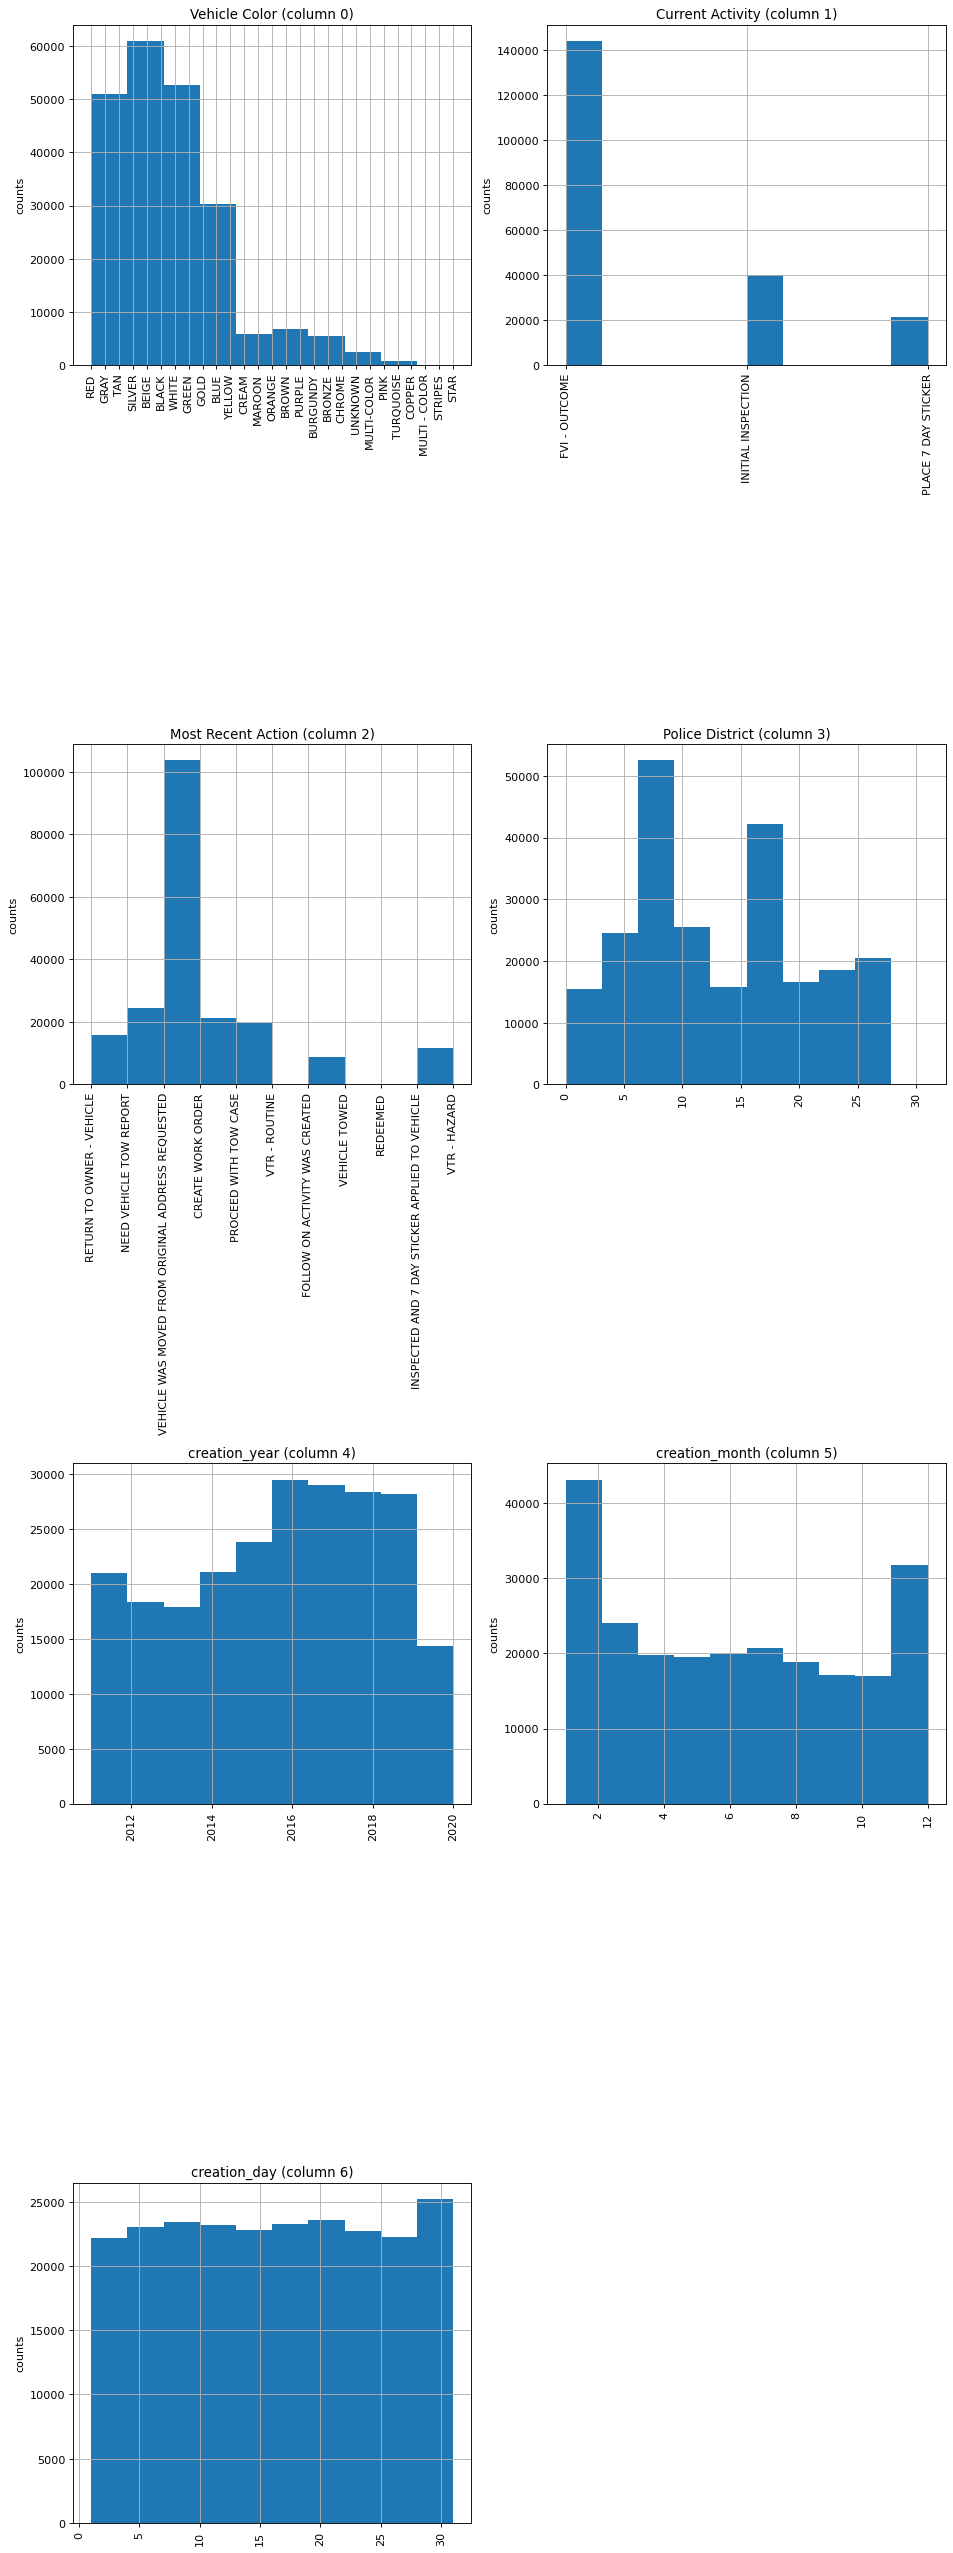

In [51]:
plotPerColumnDistribution(dedup_clean_data_show, 14, 2)

Correlation matrix:

/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/3125595058.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns') # drop columns with NaN


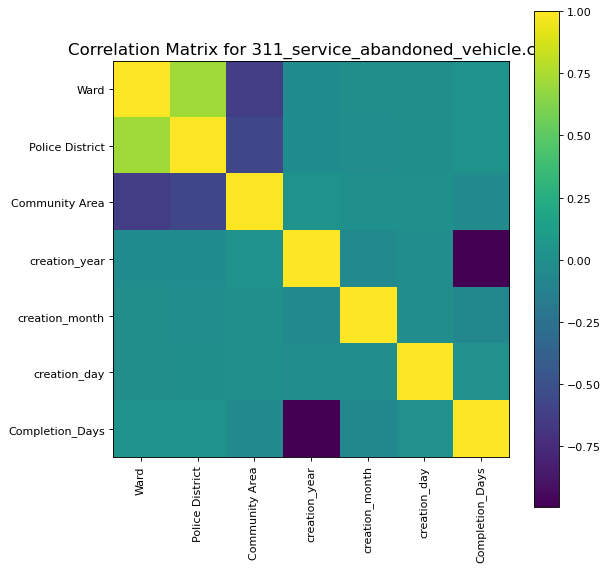

In [52]:
plotCorrelationMatrix(dedup_clean_data_show, 8)

Scatter and density plots:

/var/folders/4l/0fc5xvvd01g47wjlznw52ghm0000gn/T/ipykernel_64641/844214064.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns')


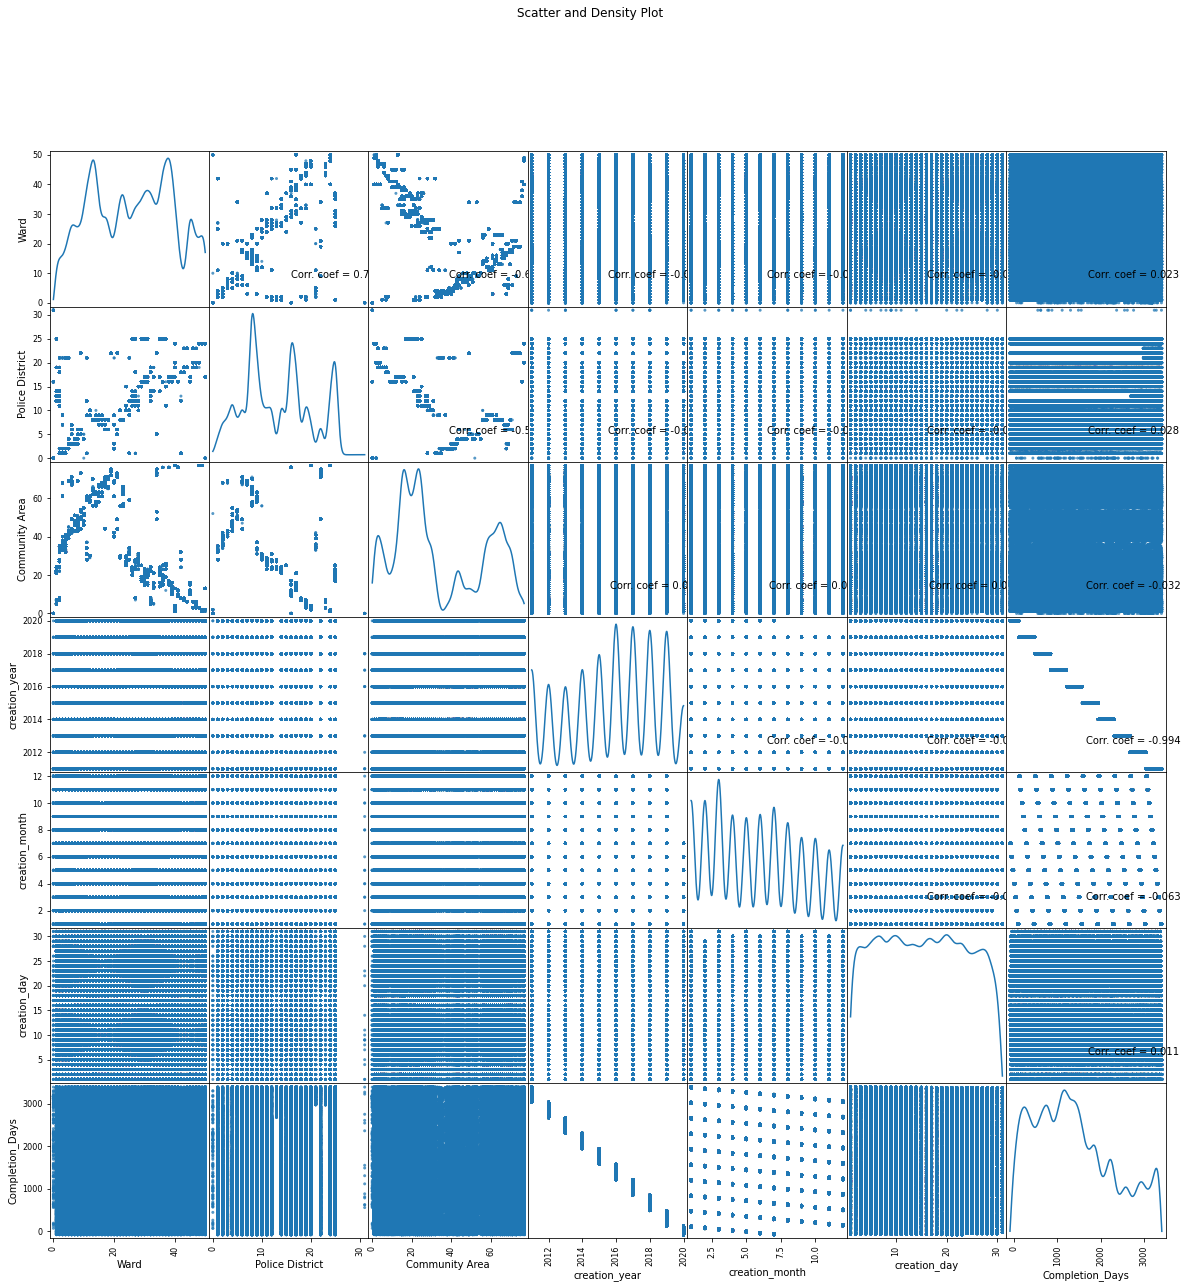

In [53]:
plotScatterMatrix(dedup_clean_data_show, 20, 10)

## 3. Data preprocessing

In [54]:
dedup_clean_data.head()

,Vehicle Make/Model,Vehicle Color,Current Activity,Most Recent Action,ZIP Code,Ward,Police District,Community Area,Latitude,Longitude,creation_year,creation_month,creation_day,Completion_Days
0,NaN,NaN,NaN,NaN,60619.0,6.0,3.0,69.0,41.761761,-87.620146,2013,1,8,2666
1,NaN,NaN,NaN,NaN,60601.0,42.0,1.0,32.0,41.884262,-87.617296,2011,1,13,3392
2,NaN,RED,NaN,NaN,NaN,37.0,25.0,25.0,41.909527,-87.745257,2011,1,14,3391
3,NaN,NaN,NaN,NaN,60601.0,42.0,1.0,32.0,41.887331,-87.617133,2012,1,20,3020
4,NaN,NaN,NaN,NaN,60644.0,28.0,15.0,25.0,41.877796,-87.745662,2011,1,24,3381


In [55]:
dedup_clean_data.isna().sum(axis=0)

Vehicle Make/Model    21096
Vehicle Color         15363
Current Activity      25651
Most Recent Action    26590
ZIP Code                109
Ward                      0
Police District           0
Community Area            0
Latitude                617
Longitude               617
creation_year             0
creation_month            0
creation_day              0
Completion_Days           0
dtype: int64

### 3.1 Class features

In [56]:
categorical_features = ['Vehicle Make/Model', 'Vehicle Color', 'Current Activity', 'Most Recent Action']
numerical_features = ['ZIP Code','Ward','Police District','Community Area','Latitude','Longitude','creation_year','creation_month','creation_day']
ordinal_class_feature = ['Current Activity']
multi_class_features = ['Vehicle Make/Model', 'Vehicle Color', 'Most Recent Action']

### 3.2 Impute the numerical NAs:

In [57]:
# filling NA with mean value
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
dedup_clean_data[numerical_features] = pd.DataFrame(imp.fit_transform(dedup_clean_data[numerical_features]))
dedup_clean_data.isna().sum(axis=0)

Vehicle Make/Model    21096
Vehicle Color         15363
Current Activity      25651
Most Recent Action    26590
ZIP Code                  0
Ward                      0
Police District           0
Community Area            0
Latitude                  0
Longitude                 0
creation_year             0
creation_month            0
creation_day              0
Completion_Days           0
dtype: int64

### 3.2 Impute the Categorical NAs

In [58]:
# filling NA with most common class
dedup_clean_data[categorical_features] = dedup_clean_data[categorical_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
dedup_clean_data.isna().sum(axis=0)

Vehicle Make/Model    0
Vehicle Color         0
Current Activity      0
Most Recent Action    0
ZIP Code              0
Ward                  0
Police District       0
Community Area        0
Latitude              0
Longitude             0
creation_year         0
creation_month        0
creation_day          0
Completion_Days       0
dtype: int64

### 3.3 Handling with categorical and text variables

In [59]:
data = dedup_clean_data.copy()

X = data[multi_class_features]
ohe = OneHotEncoder()
ohe.fit_transform(X).toarray()
multi_class_encoded_data = pd.DataFrame(ohe.fit_transform(X).toarray()).rename(columns={i: v 
                        for i, v in enumerate(ohe.get_feature_names())})

Y = data[ordinal_class_feature]
# specify the order with categories parameter
enc = OrdinalEncoder(categories=[('PLACE 7 DAY STICKER','INITIAL INSPECTION','FVI - OUTCOME')])
ordinal_class_encoded_data = enc.fit_transform(Y)
ordinal_class_encoded_data = pd.DataFrame(ordinal_class_encoded_data).rename(columns = {0:'Current Activity'})

In [60]:
df_test = pd.concat([data[numerical_features], multi_class_encoded_data,ordinal_class_encoded_data,data['Completion_Days']], axis=1)

In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231608 entries, 0 to 231607
Columns: 205 entries, ZIP Code to Completion_Days
dtypes: float64(204), int64(1)
memory usage: 362.2 MB


### 3.4 Standard Scaling

### 3.5 Train Test Split

In [62]:
# split data into training and testing
X = df_test.drop(columns = ['Completion_Days'])
y = df_test['Completion_Days']

In [63]:


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

train_data = pd.concat([X_train,y_train], axis=1)
test_data = pd.concat([X_test,y_test], axis=1)

### 3.5 Scale the features into standard scaling

In [64]:


max_abs_scaler = MaxAbsScaler()
X_train = max_abs_scaler.fit_transform(X_train)
X_test = max_abs_scaler.transform(X_test)

## 4.Model Training

### 4.1 A simple Linear regression

When we model a linear relationship between a response and just one explanatory variable, this is called simple linear regression. I want to predict the days to complete the service and then, our response variable is creation_days. However, for a simple model we also need to select a feature. When I look at the columns of the dataset, police district seemed the most important feature. When we examine the correlation matrix, we may observe that price has the highest correlation coefficient with police district and this also supports my opinion. Thus, I decided to use living area (sqft) as feature but if you want to examine the relationship between price and another feature, you may prefer that feature.

In [65]:



lr = LinearRegression()
X_train = np.array(train_data['Police District'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['Completion_Days'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['Police District'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['Completion_Days'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,df_test[['Police District']],df_test['Completion_Days'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))

r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression','-',rmsesm,rtrsm,'-',rtesm,'-',cv]
evaluation

Average Price for Test Data: 1510.144
Intercept: 1467.7774126905858
Coefficient: [4.03588392]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,988.344,0.001,-,0.001,-,-27.27


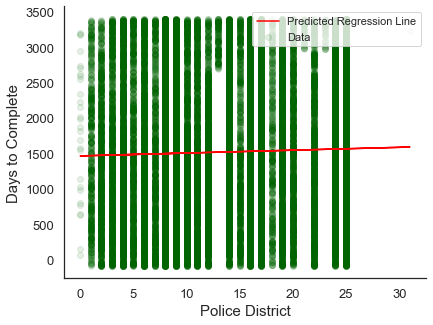

In [66]:
# let's show our result for this prediction
sns.set(style="white", font_scale=1)
plt.figure(figsize=(6.5,5))
plt.scatter(X_test,y_test,color='darkgreen',label="Data", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Police District", fontsize=15)
plt.ylabel("Days to Complete", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

Obviously, this is far from precise for a simple linear regression for the correct value. Let's figure out some regression with the whole features

### 4.2 Multiple Feature Linear Regression

The R-squared increases when the number of features increase. Because of this, sometimes a more robust evaluator is preferred to compare the performance between different models. This evaluater is called adjusted R-squared and it only increases, if the addition of the variable reduces the MSE. 

In [67]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

Now let's dig in

In [68]:
complex_model_1 = LinearRegression()
complex_model_1.fit(X_train,y_train)

print('Intercept: {}'.format(complex_model_1.intercept_))
print('Coefficients: {}'.format(complex_model_1.coef_))

pred = complex_model_1.predict(X_train)
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_train,pred)),'.3f'))
rtrcm = float(format(complex_model_1.score(X_train,y_train),'.3f'))
artrcm = float(format(adjustedR2(complex_model_1.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm = float(format(complex_model_1.score(X_test,y_test),'.3f'))
artecm = float(format(adjustedR2(complex_model_1.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv = float(format(cross_val_score(complex_model_1,X,y,cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-4','all features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 1467.7774126905858
Coefficients: [4.03588392]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-4,all features,987.905,0.001,-0.0,0.001,-0.004,1.00
0,Simple Linear Regression,-,988.344,0.001,-,0.001,-,-27.27


### 4.3 Ridge(L1) Regularization

In [69]:

complex_model_R = linear_model.Ridge(alpha=1)
complex_model_R.fit(X_train,y_train)

pred1 = complex_model_R.predict(X_test)
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrcm1 = float(format(complex_model_R.score(X_train,y_train),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_R.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm1 = float(format(complex_model_R.score(X_test,y_test),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_R.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv1 = float(format(cross_val_score(complex_model_R,X,y,cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=100)
complex_model_R.fit(X_train,y_train)

pred2 = complex_model_R.predict(X_test)
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(X_train,y_train),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm2 = float(format(complex_model_R.score(X_test,y_test),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,X,y,cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=1000)
complex_model_R.fit(X_train,y_train)

pred3 = complex_model_R.predict(X_test)
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrcm3 = float(format(complex_model_R.score(X_train,y_train),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_R.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm3 = float(format(complex_model_R.score(X_test,y_test),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_R.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv3 = float(format(cross_val_score(complex_model_R,X,y,cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Ridge Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Ridge Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-4,all features,987.905,0.001,-0.0,0.001,-0.004,1.00
2,Ridge Regression,"alpha=1, all features",988.344,0.001,-0.0,0.001,-0.004,1.00
3,Ridge Regression,"alpha=100, all features",988.344,0.001,-0.0,0.001,-0.004,1.00
4,Ridge Regression,"alpha=1000, all features",988.344,0.001,-0.0,0.001,-0.004,1.00
0,Simple Linear Regression,-,988.344,0.001,-,0.001,-,-27.27


### 4.4 Lasso Regression

In [70]:
complex_model_L = linear_model.Lasso(alpha=1)
complex_model_L.fit(X_train,y_train)

pred1 = complex_model_L.predict(X_test)
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrcm1 = float(format(complex_model_L.score(X_train,y_train),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_L.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm1 = float(format(complex_model_L.score(X_test,y_test),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_L.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv1 = float(format(cross_val_score(complex_model_L,X,y,cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=100)
complex_model_L.fit(X_train,y_train)

pred2 = complex_model_L.predict(X_test)
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrcm2 = float(format(complex_model_L.score(X_train,y_train),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_L.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm2 = float(format(complex_model_L.score(X_test,y_test),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_L.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv2 = float(format(cross_val_score(complex_model_L,X,y,cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=1000)
complex_model_L.fit(X_train,y_train)

pred3 = complex_model_L.predict(X_test)
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrcm3 = float(format(complex_model_L.score(X_train,y_train),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_L.score(X_train,y_train),train_data.shape[0],204),'.3f'))
rtecm3 = float(format(complex_model_L.score(X_test,y_test),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_L.score(X_test,y_test),test_data.shape[0],204),'.3f'))
cv3 = float(format(cross_val_score(complex_model_L,X,y,cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Lasso Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Lasso Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-4,all features,987.905,0.001,-0.0,0.001,-0.004,1.000
2,Ridge Regression,"alpha=1, all features",988.344,0.001,-0.0,0.001,-0.004,1.000
3,Ridge Regression,"alpha=100, all features",988.344,0.001,-0.0,0.001,-0.004,1.000
4,Ridge Regression,"alpha=1000, all features",988.344,0.001,-0.0,0.001,-0.004,1.000
5,Lasso Regression,"alpha=1, all features",988.344,0.001,-0.0,0.001,-0.004,1.000
6,Lasso Regression,"alpha=100, all features",988.344,0.001,-0.001,0.000,-0.004,0.887
7,Lasso Regression,"alpha=1000, all features",988.344,0.000,-0.001,-0.000,-0.005,-7.620
0,Simple Linear Regression,-,988.344,0.001,-,0.001,-,-27.270


### 4.5 Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures
evaluation_poly = pd.DataFrame({'Model': [],
                                'Details':[],
                                'Root Mean Squared Error (RMSE)':[],
                                'R-squared (training)':[],
                                'Adjusted R-squared (training)':[],
                                'R-squared (test)':[],
                                'Adjusted R-squared (test)':[],
                                '5-Fold Cross Validation':[]})


polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(X)
X_trainpoly = polyfeat.fit_transform(X_train)
X_testpoly = polyfeat.fit_transform(X_test)
poly = linear_model.LinearRegression().fit(X_trainpoly, y_train)

pred1 = poly.predict(X_testpoly)
rmsepoly1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred1)),'.3f'))
rtrpoly1 = float(format(poly.score(X_trainpoly,y_train),'.3f'))
rtepoly1 = float(format(poly.score(X_testpoly,y_test),'.3f'))
cv1 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,y,cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(X)
X_trainpoly = polyfeat.fit_transform(X_train)
X_testpoly = polyfeat.fit_transform(X_test)
poly = linear_model.LinearRegression().fit(X_trainpoly, y_train)

pred2 = poly.predict(X_testpoly)
rmsepoly2 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred2)),'.3f'))
rtrpoly2 = float(format(poly.score(X_trainpoly,y_train),'.3f'))
rtepoly2 = float(format(poly.score(X_testpoly,y_test),'.3f'))
cv2 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,y,cv=5).mean(),'.3f'))

r = evaluation_poly.shape[0]
evaluation_poly.loc[r] = ['Polynomial Regression','degree=2, all features, no preprocessing',rmsepoly1,rtrpoly1,'-',rtepoly1,'-',cv1]
evaluation_poly.loc[r+1] = ['Polynomial Regression','degree=3, all features, no preprocessing',rmsepoly2,rtrpoly2,'-',rtepoly2,'-',cv2]

evaluation_poly_temp = evaluation_poly[['Model','Details','Root Mean Squared Error (RMSE)','R-squared (training)','R-squared (test)','5-Fold Cross Validation']]
evaluation_poly_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)

### 4.6 Potential Reasons of Failed Prediction

As we know from this evaluation form, we should choose the multiregression 4 which has the lowest RMSE when comes to 5 folds corss validation.

### A.The kernel died after the polynomial regression

I don't know why but the kernel just keep breaking down after I run the code above for the polynomial regression, so I have to put it in the markdown and hopefully this can somehow give me a better solution since the complexity of the model do grows up which leads to the higher variance.

### B. The outlier processing is raw

Since that I obtained this dataset from a public dataset which is not from a professionally dataset website for example from Kaggle or UCI, the dataset is really raw and I haven't process the outlier outside of distribution of 95%. I believe by process this outliers the model will be more accurate and concise.

### C. The lack of grid search

Due to the lack of the dataset, I haven't done the grid search which can definitely miss some of the models in the best practice.